In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#http://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html

# Use CoNLL 2002 data to build a NER system: Understand the dataset

In [10]:
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [11]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [12]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

Wall time: 2.88 s


In [13]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

In [14]:
len(train_sents)
len(test_sents)

8323

1517

# Use CoNLL 2002 data to build a NER system: Define features

In [15]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [16]:
sent2features(train_sents[0])[0]

{'+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': '(',
 'BOS': True,
 'bias': 1.0,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': 'melbourne',
 'word[-2:]': 'ne',
 'word[-3:]': 'rne'}

In [19]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

Wall time: 2.57 s


# Use CoNLL 2002 data to build a NER system: Learn and evaluate the CRF

In [30]:
#We are using L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.
crf = sklearn_crfsuite.CRF(algorithm='lbfgs',c1=0.1,c2=0.1,max_iterations=100,all_possible_transitions=True)

In [31]:
%%time
crf.fit(X_train, y_train)

Wall time: 42.8 s


CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [32]:
labels = list(crf.classes_)
#There is much more O entities in data set, but we’re more interested in other entities. 
#To account for this we’ll use averaged F1 score computed for all labels except for O. 
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [33]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7964686316443963

In [34]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.810     0.784     0.797      1084
      I-LOC      0.690     0.637     0.662       325
     B-MISC      0.731     0.569     0.640       339
     I-MISC      0.699     0.589     0.639       557
      B-ORG      0.807     0.832     0.820      1400
      I-ORG      0.852     0.786     0.818      1104
      B-PER      0.850     0.884     0.867       735
      I-PER      0.893     0.943     0.917       634

avg / total      0.809     0.787     0.796      6178



# Use CoNLL 2002 data to build a NER system: Hyper-parameter Optimization

In [23]:
%%time
#Hyperparameter Optimization
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=5,
                        #n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.3min finished


Wall time: 5min 1s


In [24]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.0781505402214977, 'c2': 0.027538713755264611}
best CV score: 0.7483578392485118
model size: 1.46M


Dark blue => 0.7255631423409018 , dark red =>  0.7483578392485118


C:\Users\gmanish\AppData\Local\Continuum\Anaconda\envs\py36\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


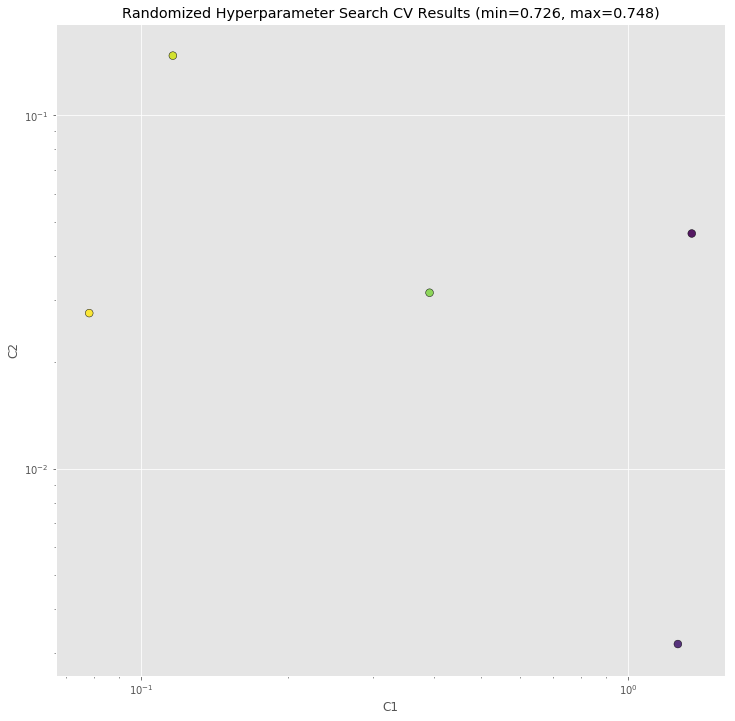

In [30]:
#Check parameter space
#A chart which shows which c1 and c2 values have RandomizedSearchCV checked. 
#Red color means better results, blue means worse.
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue =>",min(_c),", dark red => ", max(_c))
fig.show()

In [31]:
#Check best estimator on our test data
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.802     0.780     0.791      1084
      I-LOC      0.660     0.615     0.637       325
     B-MISC      0.716     0.566     0.633       339
     I-MISC      0.683     0.591     0.633       557
      B-ORG      0.809     0.832     0.820      1400
      I-ORG      0.853     0.778     0.814      1104
      B-PER      0.846     0.883     0.864       735
      I-PER      0.901     0.943     0.921       634

avg / total      0.805     0.783     0.793      6178



# Use CoNLL 2002 data to build a NER system: Feature Importances

In [32]:
#Let’s check what classifier learned
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.694639
I-ORG  -> I-ORG   7.259915
B-MISC -> I-MISC  7.017878
B-PER  -> I-PER   6.806096
I-MISC -> I-MISC  6.742091
B-LOC  -> I-LOC   5.862913
I-PER  -> I-PER   5.372330
I-LOC  -> I-LOC   5.072028
O      -> O       4.141420
O      -> B-ORG   2.830548
O      -> B-PER   2.732827
O      -> B-LOC   1.885585
O      -> B-MISC  1.813624
B-ORG  -> O       0.508557
I-PER  -> B-LOC   0.269028
B-ORG  -> B-LOC   0.214785
B-LOC  -> B-LOC   0.210585
B-MISC -> B-ORG   0.139248
B-MISC -> O       0.050986
B-LOC  -> B-PER   -0.048293

Top unlikely transitions:
I-ORG  -> I-PER   -2.768740
I-LOC  -> B-MISC  -2.782201
B-ORG  -> I-LOC   -2.805732
I-ORG  -> B-LOC   -2.863141
I-PER  -> I-LOC   -2.907443
I-MISC -> I-ORG   -2.930344
B-PER  -> B-MISC  -3.001304
I-MISC -> B-LOC   -3.139893
I-PER  -> B-ORG   -3.165314
B-ORG  -> B-MISC  -3.199735
I-ORG  -> B-MISC  -3.346240
I-ORG  -> I-LOC   -3.501328
B-PER  -> B-PER   -3.551361
I-PER  -> B-MISC  -3.634526
B-MISC -> B-MISC

We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

In [33]:
#Check the state features:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
12.516005 B-ORG    word.lower():efe-cantabria
10.548705 B-ORG    word.lower():psoe-progresistas
9.114545 B-ORG    word.lower():petrobras
8.172920 I-ORG    -1:word.lower():l
7.990159 B-ORG    word.lower():coag-extremadura
7.456890 I-ORG    -1:word.lower():rasd
7.259249 B-LOC    +1:word.lower():finalizaron
6.976537 B-ORG    +1:word.lower():plasencia
6.905932 B-MISC   word.lower():cc2305001730
6.641231 B-ORG    word.lower():xfera
6.604577 B-ORG    -1:word.lower():distancia
6.500834 B-ORG    -1:word.lower():sociolaboral
6.475757 B-ORG    word[-2:]:-e
6.472186 B-PER    word.lower():orduña
6.455038 I-ORG    -1:word.lower():ag
6.352463 B-MISC   word.lower():diversia
6.346127 B-LOC    -1:word.lower():celebrarán
6.318568 B-ORG    word.lower():eu-ecologista
6.265923 O        word.lower():r.
6.265923 O        word[-3:]:R.
6.241269 B-LOC    -1:word.lower():cantabria
6.000572 B-PER    word.lower():valedor
5.983768 B-MISC   word.lower():competencia
5.951920 B-MISC   word.lower():justic

Note:

5.928977 I-LOC    -1:word.lower():calle: “calle” is a street in Spanish; model learns that if a previous word was “calle” then the token is likely a part of location;
            
-6.505398 O        word.isupper()


-9.218210 O        word.istitle() : UPPERCASED or TitleCased words are likely entities of some kind;